## An instrument classificator

The purpose of this model is to identify if the instrument playing in an audio
file is a clarinet or not.

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

import shutil,os



/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


We will start by obtaining the spectrogram of an .mp3 file.

To do it, we will use the library 'librosa', which a Python library designed to
analyze and manipulate audio. To this purpose, we create the following function.

In [48]:
def convert_audio_to_melspectogram(filename):
    
    # sr == sampling rate 
    x, sr = librosa.load(filename, mono=False, sr=22050)

    # If the file is in stereo, we have to convert it to mono
    if len(x.shape) == 2:
        x = librosa.to_mono(x)

    # stft is short time fourier transform
    X = librosa.stft(x)

    X_magnitude, _ = librosa.magphase(X)
    mel_scale_X = librosa.feature.melspectrogram(S=X_magnitude, sr=sr)
    mel_X_db = librosa.amplitude_to_db(mel_scale_X)
    
    # ... and plot, magic!
    librosa.display.specshow(mel_X_db, sr = sr, x_axis = 'time', y_axis = 'mel')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()

Now we can use our function to plot the spectrogram of any audio file. If the
file is a mp3, a warning will be printed when reading the file, as the first
method librosa.load() doesn't support mp3 files, and it will have to pass to a
second option.

/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


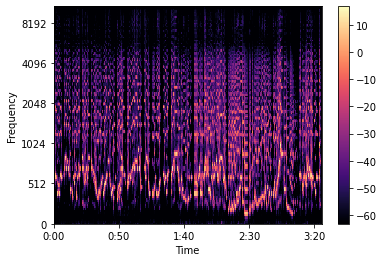

In [9]:
convert_audio_to_melspectogram('adagio_clarinet.mp3')

## Preparing the data

The dataset MEdley-solos-DB consists in thousands of .wav files from 8 different
instruments. Also, from each instrument there are 3 different subsets of .wav
files: the train, validation and test subsets. 

We are gonna pass each of these files to our function, to obtain the
mel_spectrograms of the files, which will be the input of our model. In the
process, we will save each .img in an specific folder depending on the
instrument, but not making difference between the train, validation and test
subsets of each instrument.

Nevertheless, at the moment all the files are in the same folder, regardless if
they belong to the training, validation or test subsets. Therefore, we will
create 3 different folders, one for each subset of our dataset, and move each
file to its corresponding directory.

In [83]:
""" 
path = Path()

wavs = (path/"Medley-solos-DB").ls()
wavs

# creating the directory "data" and its subdirectories
os.mkdir("data")
for subset in ["train","validation","test"]:
    os.makedirs("data/%s" % subset)

# Moving the files to the corresponding directories
for file in wavs:
    if "test" in str(file.name):
        shutil.move(str(file),"data/test")
    elif "validation" in str(file.name):
        shutil.move(str(file),"data/validation")
    else:
        shutil.move(str(file),"data/train") 
        
        
# Delete the now old Medley-solos-DB folder
os.rmdir("Medley-solos-DB")
"""

As we have move the files, we get the new list of paths to the files.

In [119]:
wavs = Path("data/train").ls() + Path("data/test").ls() + Path("data/validation").ls()
wavs

(#43142) [Path('data/train/Medley-solos-DB_training-7_913054ab-899e-529e-f32f-0dbde17425c7.wav'),Path('data/train/._Medley-solos-DB_training-7_e294be63-481e-5cd7-fda3-5505ae1c2f35.wav'),Path('data/train/._Medley-solos-DB_training-4_9524eb44-1a46-5562-f56f-94c224987ae4.wav'),Path('data/train/Medley-solos-DB_training-7_5f50f7e4-edf5-5735-f3be-e4c0adbbb69a.wav'),Path('data/train/._Medley-solos-DB_training-7_a2d14713-a1cf-5d80-fcbf-c26d9816e9ae.wav'),Path('data/train/Medley-solos-DB_training-4_aefc39c2-f450-59ef-fe6b-dc26b881b6aa.wav'),Path('data/train/Medley-solos-DB_training-4_8dee3dfa-2f41-5c70-f845-60bd54f2111b.wav'),Path('data/train/._Medley-solos-DB_training-7_3699870b-db8a-5607-fd5a-d8a24ab45166.wav'),Path('data/train/Medley-solos-DB_training-4_920557e3-e6d5-5361-f3bd-f530e4ff3a45.wav'),Path('data/train/._Medley-solos-DB_training-7_d72db52c-d0a5-5e45-f848-4a94101839e2.wav')...]

## Using fastaudio

We can directly work with the .wav files thanks to the fastaudio module from fastai.

We read the .csv files with the metadata of the .wav files, creating a pandas
dataframe.

In [20]:
df = pd.read_csv(path/"Medley-solos-DB_metadata.csv")
df.head()

,subset,instrument,instrument_id,song_id,uuid4
0,test,clarinet,0,0,0e4371ac-1c6a-51ab-fdb7-f8abd5fbf1a3
1,test,clarinet,0,0,33383119-fd64-59c1-f596-d1a23e8a0eff
2,test,clarinet,0,0,b2b7a288-e169-5642-fced-b509c06b11fc
3,test,clarinet,0,0,151b6ee4-313a-58d9-fbcb-bab73e0d426b
4,test,clarinet,0,0,b43999d1-9b5e-557f-f9bc-1b3759659858


We can get the the metada of each file using the UUID (Universal Unique
Identifier)

In [36]:
df.loc[df.uuid4 == wavs[1].name[-40:-4]]

,subset,instrument,instrument_id,song_id,uuid4
7705,test,piano,4,79,a83a4197-b50f-5348-f6f7-dbbeef7fb84c


This won't be necessary in this case since the instrument_id is already present
in the file's name. Therefore, given the files name, we can now which instrument
is playing.

In [2]:
def get_instrument_tag(file):
    instruments_ids = {0:'clarinet', 1:'distorted electric guitar', 2:'female singer', 3:'flute', 4:'piano',
5:'tenor saxophone', 6:'trumpet', 7:'violin'}
    return instruments_ids[int(file.name[-42])]

In [122]:
get_instrument_tag(wavs[1])

'violin'

Therefore, we can once again, move each file to a folder with the name of the
instrument playing.

In [125]:
""" for subset in ["train","validation","test"]:
    instruments_ids = {0:'clarinet', 1:'distorted electric guitar', 2:'female singer', 3:'flute', 4:'piano',
5:'tenor saxophone', 6:'trumpet', 7:'violin'}
    for instrument in instruments_ids.values():
        os.makedirs("data/%s/%s" % (subset,instrument)) 

# Moving the files to the corresponding directories
for subset in ["train","validation","test"]:
    [shutil.move(str(file),"data/%s/%s" %(subset,get_instrument_tag(file))) for file in wavs if subset in str(file.name)] """

## Listening the file

Using the AudioTensor class from fastaudio we can plot and listen the file with
the show method. (The player doesn't seem to work. Maybe because of the VSCode
GUI for the Jupyter Notebooks)

<AxesSubplot:>

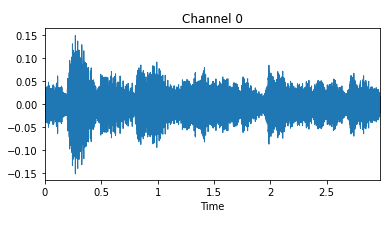

In [55]:
sample_audio = AudioTensor.create(wavs[1])
sample_audio.show()

## Creating the spectrogram of the audio files

With the AudiotoSpec class from fastaudio, it is simple to create the spetrogram
of the audio file as following:

In [3]:
# We select the parameters we want for the spectrogram
cfg = AudioConfig.BasicMelSpectrogram() # with default torchaudio parameters
audio2melspec = AudioToSpec.from_cfg(cfg)
# We extract the spectrogram
#spec = audio2melspec(sample_audio)

/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/torchaudio/functional/functional.py:358: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


And we can visualize it simply using the show method

/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


<AxesSubplot:>

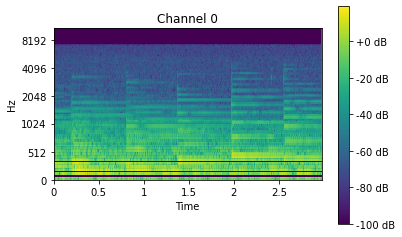

In [57]:
spec.show()

## Creating our dataloaders:
We start by creating our datablock:

In [4]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='validation'),
                 item_tfms = audio2melspec,
                 get_y=parent_label)

We can now create our dataloader

In [5]:
path = Path("data")
print(path)
dls = aud_digit.dataloaders(path, bs=8)

data


/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/antonfsp/miniconda3/envs/fast_ia_course/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


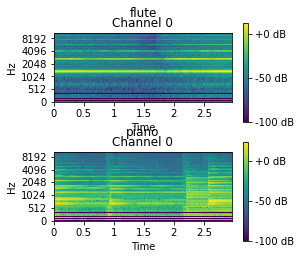

In [6]:
dls.show_batch()

## Training

We have to modify the learner to accept single-channel images. This is
equivalent to prepare the learner for be trained with greyscale images.d

In [7]:
def alter_learner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [8]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics=accuracy)

In [9]:
n_c = dls.one_batch()[0].shape[1]; n_c

1

In [10]:
alter_learner(learn, n_c)

We can find the correc learn rate:

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.001737800776027143)

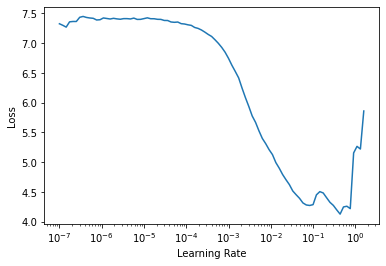

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(5, 0.04)

epoch,train_loss,valid_loss,accuracy,time
0,0.540094,1.893376,0.396394,07:08
1,0.164181,1.482131,0.626503,06:16
2,0.094853,1.524201,0.735260,05:54
3,0.027179,0.654415,0.801660,06:17
4,0.007687,0.598341,0.822839,06:19


In [13]:
learn.unfreeze()

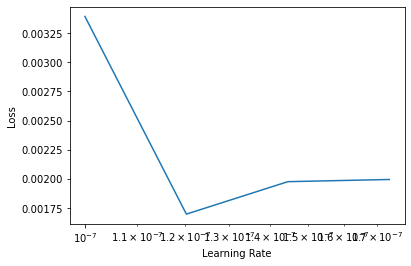

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(12, lr_max=slice(1e-8,1e-7))

epoch,train_loss,valid_loss,accuracy,time
0,0.018884,0.584346,0.844877,06:27
1,0.011409,0.623694,0.831712,06:21
2,0.007184,0.566161,0.850315,06:26
3,0.016793,0.611789,0.838867,06:21
4,0.012656,0.600059,0.836863,06:27
5,0.007549,0.572681,0.829994,06:26
6,0.011126,0.568420,0.836291,06:33
7,0.012963,0.594881,0.835432,06:21
8,0.007636,0.562398,0.834574,06:29
9,0.012439,0.568561,0.844877,06:24


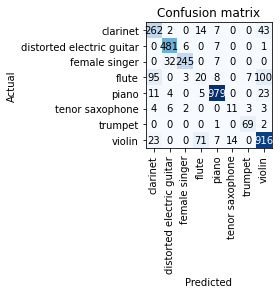

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [34]:
learn.export()

In [36]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.get_preds(Path('data/test/clarinet/._Medley-solos-DB_test-0_0a282672-c22c-59ff-faaa-ff9eb73fc8e6.wav'))

TypeError: list indices must be integers or slices, not PosixPath

In [41]:
sample_audio = AudioTensor.create(Path('data/train/clarinet/._Medley-solos-DB_training-0_0af2665a-290d-5042-fe8f-03171f539b50.wav'))

formats: can't open input file `data/train/clarinet/._Medley-solos-DB_training-0_0af2665a-290d-5042-fe8f-03171f539b50.wav': WAVE: RIFF header not found


RuntimeError: Error loading audio file: failed to open file.

In [42]:
wavs

NameError: name 'wavs' is not defined